In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='3'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=11,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="gtea",
    architecture="mstcn-new",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=1,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/gtea//results/em-mstcn-split1-mseloss/",
    project_name="gtea-split-1",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 11, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'gtea', 'architecture': 'mstcn-new', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 1, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/gtea//results/em-mstcn-split1-mseloss/', 'project_name': 'gtea-split-1', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/splits/train.split1.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/splits/test.split1.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split': '/mnt/ssd/all_users/dipika/ms_tcn/data/gtea/semi_

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 21
Number of videos not found in train fold is 0
Number of videos logged in test fold is 7
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [10]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [11]:
selected_frames_dict = pickle.load(open("data/gtea_selectedframes.pkl", 'rb'))
# loaded_vidid_selected_frames
boundary_frames_dict = pickle.load(open("data/gtea_boundary_annotations.pkl", "rb"))
# video_id_boundary_frames

In [12]:
loaded_mean_var_actions = pickle.load(open("data/gtea_meanvar_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[label_id_to_label_name[cur_class]]
    mean_class = mean_class
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [13]:
prob_video_each_segment_dict = {}

In [14]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[i]
        label_next_ele = labels[i + 1]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele)

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
        prob_video = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
#     global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames_indices[0]
        if start_ele_idx > 0:
            start_ele_label_idx = selected_frames_labels[0]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames_indices[:-1]):
            next_ele = selected_frames_indices[i + 1]
            label_cur_ele = selected_frames_labels[i]
            label_next_ele = selected_frames_labels[i + 1]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = selected_frames_labels[-1]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames_indices[-1] - 1, \
                                                                         :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        
        selected_frames_indices_and_labels = selected_frames_dict[video_id]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_frames_indices[i], selected_frames_indices[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_frames_indices[i]) or (estimated_boundary > selected_frames_indices[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(boundary_frames_dict[video_id][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = boundary_frames_dict[video_id][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=config.num_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
def get_single_random(video_ids, len_frames, device):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((len(video_ids), len_frames), dtype=torch.long, device=device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        frame_idx_tensor = torch.from_numpy(np.array(selected_frames_indices))
        frame_labels = torch.from_numpy(np.array(selected_frames_labels)).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = frame_labels

    return boundary_target_tensor

In [21]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/gtea//results/em-mstcn-split1-mseloss/'

In [22]:
initialize_epoch = 60
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(200):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        boundary_target_tensor = get_single_random(item[4], item_2.shape[1], item_2.device)
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, boundary_target_tensor)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4])
                loss += es_loss
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    if epoch == initialize_epoch:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-initial-15-epochs.wt")
    # Calculating Expectation Step
    model.eval()
    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4])
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 0, Iteration 0, Current loss 9.703436851501465 Accuracy 9.669893852793654
Calculating Validation Data Accuracy
Validation:: Epoch 0, Probability Accuracy 23.402854006586168
Starting Training
Training:: Epoch 1, Iteration 0, Current loss 8.307132720947266 Accuracy 20.738440303657693
Calculating Validation Data Accuracy
Validation:: Epoch 1, Probability Accuracy 23.402854006586168
Starting Training
Training:: Epoch 2, Iteration 0, Current loss 7.6759467124938965 Accuracy 22.534880994254895
Calculating Validation Data Accuracy
Validation:: Epoch 2, Probability Accuracy 23.402854006586168
Starting Training
Training:: Epoch 3, Iteration 0, Current loss 7.38355016708374 Accuracy 22.34223300970874
Calculating Validation Data Accuracy
Validation:: Epoch 3, Probability Accuracy 23.402854006586168
Starting Training
Training:: Epoch 4, Iteration 0, Current loss 7.10694694519043 Accuracy 21.020408163265305
Calculating Validation Data Accuracy
Validation:: Epoch 4

Training:: Epoch 39, Iteration 0, Current loss 1.4073978662490845 Accuracy 65.42846163699244
Calculating Validation Data Accuracy
Validation:: Epoch 39, Probability Accuracy 50.21953896816685
Starting Training
Training:: Epoch 40, Iteration 0, Current loss 1.4607210159301758 Accuracy 66.3919742027947
Calculating Validation Data Accuracy
Validation:: Epoch 40, Probability Accuracy 50.28540065861691
Starting Training
Training:: Epoch 41, Iteration 0, Current loss 1.3699297904968262 Accuracy 69.79327801996907
Calculating Validation Data Accuracy
Validation:: Epoch 41, Probability Accuracy 50.735455543358945
Starting Training
Training:: Epoch 42, Iteration 0, Current loss 1.3756524324417114 Accuracy 65.12290701816886
Calculating Validation Data Accuracy
Validation:: Epoch 42, Probability Accuracy 50.636663007683865
Starting Training
Training:: Epoch 43, Iteration 0, Current loss 1.3209847211837769 Accuracy 68.79023605150215
Calculating Validation Data Accuracy
Validation:: Epoch 43, Probab

Training:: Epoch 76, Iteration 0, Current loss 1.222724365453125 Accuracy 74.01926239135541
Calculating Validation Data Accuracy
Validation:: Epoch 76, Probability Accuracy 60.548847420417125
Starting Training
Training:: Epoch 77, Iteration 0, Current loss 1.0911744933846115 Accuracy 73.47854640980735
Calculating Validation Data Accuracy
Validation:: Epoch 77, Probability Accuracy 59.18770581778266
Starting Training
Training:: Epoch 78, Iteration 0, Current loss 1.220068288677823 Accuracy 73.46938775510205
Calculating Validation Data Accuracy
Validation:: Epoch 78, Probability Accuracy 60.66959385290889
Starting Training
Training:: Epoch 79, Iteration 0, Current loss 1.1408906058836594 Accuracy 71.69183516764781
Calculating Validation Data Accuracy
Validation:: Epoch 79, Probability Accuracy 59.91218441273326
Starting Training
Training:: Epoch 80, Iteration 0, Current loss 1.1780120300050074 Accuracy 72.63108940820835
Calculating Expectation
Epoch 80 iter 0
Train Boundary avergage erro

Training:: Epoch 111, Iteration 0, Current loss 0.9007627058452051 Accuracy 70.66454534328723
Calculating Validation Data Accuracy
Validation:: Epoch 111, Probability Accuracy 60.49396267837541
Starting Training
Training:: Epoch 112, Iteration 0, Current loss 0.8744882619364484 Accuracy 72.83085013146363
Calculating Validation Data Accuracy
Validation:: Epoch 112, Probability Accuracy 59.9231613611416
Starting Training
Training:: Epoch 113, Iteration 0, Current loss 0.8275787287186802 Accuracy 73.8233680746023
Calculating Validation Data Accuracy
Validation:: Epoch 113, Probability Accuracy 60.37321624588365
Starting Training
Training:: Epoch 114, Iteration 0, Current loss 0.8035322197323105 Accuracy 73.8608305274972
Calculating Validation Data Accuracy
Validation:: Epoch 114, Probability Accuracy 60.13172338090011
Starting Training
Training:: Epoch 115, Iteration 0, Current loss 0.8771680041538297 Accuracy 72.875157629256
Calculating Expectation
Epoch 115 iter 0
Train Boundary avergag

Validation:: Epoch 145, Probability Accuracy 59.86827661909989
Starting Training
Training:: Epoch 146, Iteration 0, Current loss 0.7881554088737159 Accuracy 71.46101438304315
Calculating Validation Data Accuracy
Validation:: Epoch 146, Probability Accuracy 60.74643249176729
Starting Training
Training:: Epoch 147, Iteration 0, Current loss 0.7339473687584016 Accuracy 71.85646798673234
Calculating Validation Data Accuracy
Validation:: Epoch 147, Probability Accuracy 58.36443468715697
Starting Training
Training:: Epoch 148, Iteration 0, Current loss 0.7907758038048079 Accuracy 71.52714490300743
Calculating Validation Data Accuracy
Validation:: Epoch 148, Probability Accuracy 60.0
Starting Training
Training:: Epoch 149, Iteration 0, Current loss 0.6882155974402366 Accuracy 70.70791195716835
Calculating Validation Data Accuracy
Validation:: Epoch 149, Probability Accuracy 59.25356750823271
Starting Training
Training:: Epoch 150, Iteration 0, Current loss 0.6992430396508769 Accuracy 71.64921

Validation:: Epoch 180, Probability Accuracy 60.41712403951701
Starting Training
Training:: Epoch 181, Iteration 0, Current loss 0.6682146351272842 Accuracy 71.85120459368369
Calculating Validation Data Accuracy
Validation:: Epoch 181, Probability Accuracy 60.944017563117455
Starting Training
Training:: Epoch 182, Iteration 0, Current loss 0.7170035104566842 Accuracy 70.63659854357529
Calculating Validation Data Accuracy
Validation:: Epoch 182, Probability Accuracy 59.857299670691546
Starting Training
Training:: Epoch 183, Iteration 0, Current loss 0.7210968003331155 Accuracy 71.27871464612933
Calculating Validation Data Accuracy
Validation:: Epoch 183, Probability Accuracy 61.19648737650933
Starting Training
Training:: Epoch 184, Iteration 0, Current loss 0.6320933264410298 Accuracy 71.37728459530027
Calculating Validation Data Accuracy
Validation:: Epoch 184, Probability Accuracy 59.64873765093304
Starting Training
Training:: Epoch 185, Iteration 0, Current loss 0.6829315258576409 Ac

In [23]:
best_val_acc

68.48518111964874

In [ ]:
#196 epch = 68.3

In [23]:
print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Validation:: Epoch 16, Probability Accuracy 34.696550605236816


In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [27]:
# model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-best-model.wt"))
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [28]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 34.696550605236816


In [29]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 304.592
Train From boundary avergage accuracy = 56.742


In [30]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
    selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
    selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)


In [36]:
selected_frames_indices

[70, 266, 804, 1432, 1676, 1774]

In [38]:
boundary_frames_dict[cur_vidid + ".txt"]

[369, 674, 1224, 1744, 1794, 1845]

Min prob 0 = 0.0
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 0.0
Min prob 4 = 6.392332920294135e-162


(0, 1846)

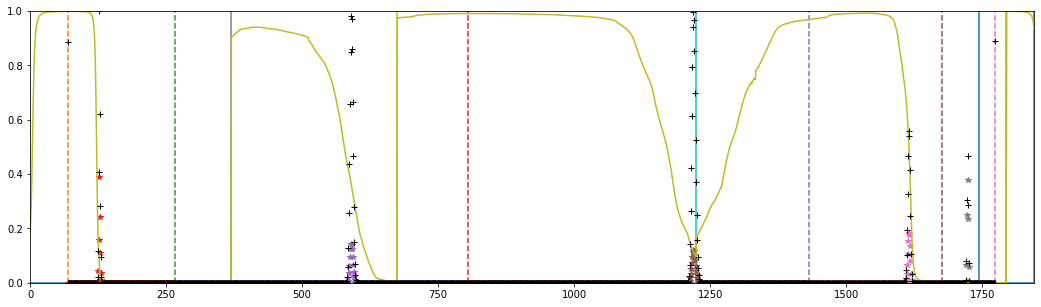

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in selected_frames_indices:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in boundary_frames_dict[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(selected_frames_indices[i], 
                   selected_frames_indices[i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]])
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames_indices[0] - 1, selected_frames_indices[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

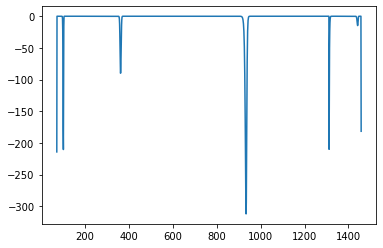

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

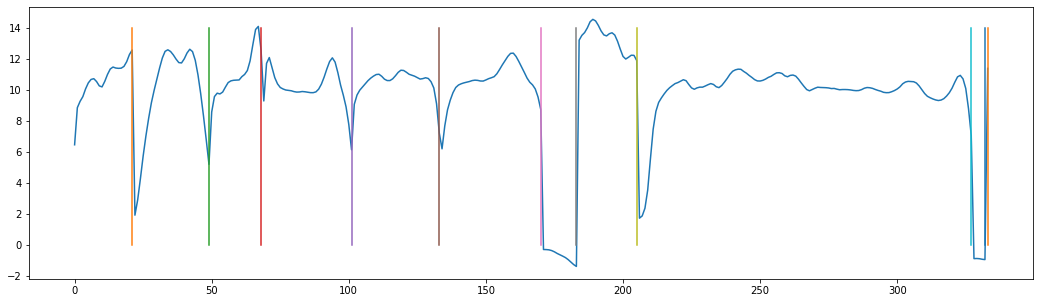

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss